## Precipitation extremes

In [17]:
import glob

import xarray as xr
import numpy as np
import xesmf as xe
import dask.diagnostics
import geopandas as gp

import cmocean
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

import spatial_selection
import plotting

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
dask.diagnostics.ProgressBar().register()

In [4]:
start_date = '1995-01-01'
end_date = '2014-12-31'

In [5]:
aus_shape = gp.read_file('/g/data/xv83/dbi599/shapefiles/australia/australia.shp')

In [6]:
rx1day_files = {}
cdd_files = {}
cwd_files = {}
prcptot_files = {}

In [7]:
rx1day_annual_mean = {}

In [8]:
def read_intesity_data(infile, regrid=False, time_bounds=None):
    """Read precipitation intensity index and calculate annual mean.
    
    e.g. rx1day
    
    Parameters
    ----------
    infile (str)
    regrid (xarray Dataset) - grid to remap to
    time_bounds (list)
    
    """
    
    ds = xr.open_dataset(infile)
    if time_bounds:
        start_date, end_date = time_bounds
        ds = ds.sel({'time': slice(start_date, end_date)})
    annual_mean = ds.mean('time', keep_attrs=True)
    if type(regrid) == xr.core.dataset.Dataset:
        regridder = xe.Regridder(ds, regrid, "bilinear")
        annual_mean = regridder(annual_mean)    
    annual_mean = spatial_selection.select_shapefile_regions(annual_mean, aus_shape)    
    annual_mean = annual_mean.compute()
    
    return annual_mean

## rx1day

In [9]:
rx1day_files['AGCD'] = '/g/data/xv83/dbi599/indices/rx1day_year_AGCD_v1_r005_1900-2021.nc'
rx1day_files['ACCESS-CM2'] = '/g/data/xv83/dbi599/indices/rx1day_year_ACCESS-CM2_historical_r4i1p1f1_gn_1850-2014.nc'
rx1day_files['NorESM2-MM'] = '/g/data/xv83/dbi599/indices/rx1day_year_NorESM2-MM_historical_r1i1p1f1_gn_1850-2014.nc'

In [28]:
rx1day_annual_mean['AGCD'] = read_intesity_data(
    rx1day_files['AGCD'], regrid=False, time_bounds=[start_date, end_date]
)

In [29]:
for model in ['ACCESS-CM2', 'NorESM2-MM']:
    rx1day_annual_mean[model] = read_intesity_data(
        rx1day_files[model], regrid=rx1day_annual_mean['AGCD'], time_bounds=[start_date, end_date]
    )

/g/data/xv83/dbi599/model-evaluation/pr_rx1day_CCAM-NorESM2-MM_1995-01-01_2014-12-31.png


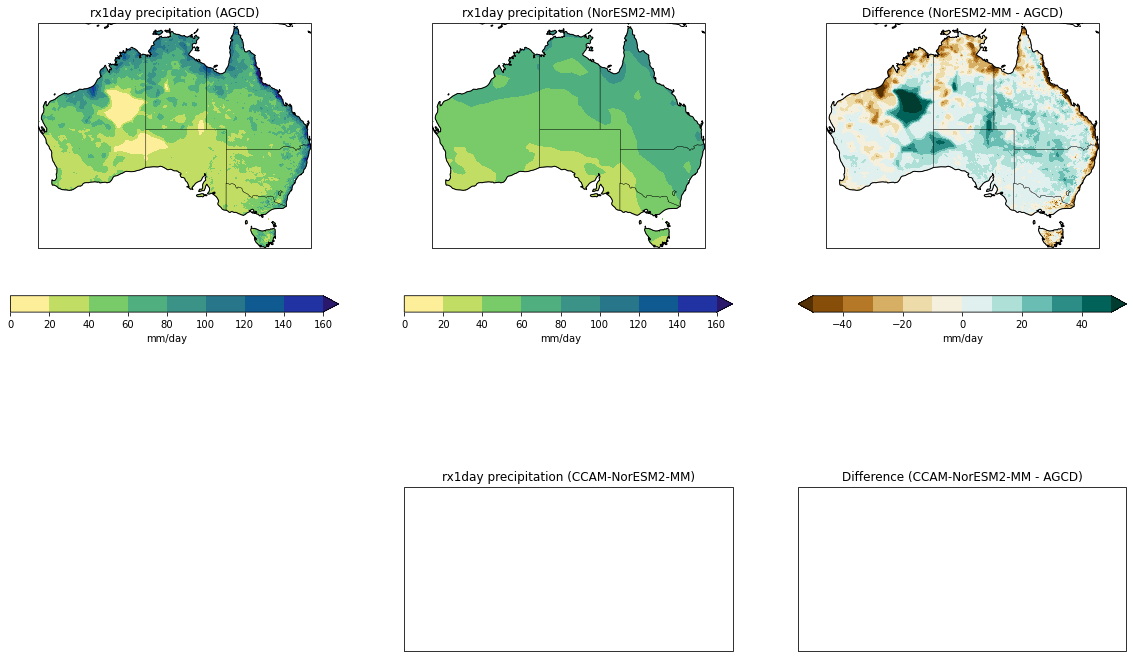

In [35]:
plotting.compare_agcd_gcm_rcm(
    rx1day_annual_mean['AGCD']['RX1day'],
    rx1day_annual_mean['NorESM2-MM']['RX1day'],
    'pr',
    'rx1day',
    'NorESM2-MM',
    'CCAM',
    start_date,
    end_date,
    [0, 20, 40, 60, 80, 100, 120, 140, 160],
    [-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50],
    rcm_da=None,
)